In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

In [ ]:
# load the dataset
traffic_df = pd.read_csv("Traffic.csv")

In [ ]:
# convert to datetime type
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

In [ ]:
# set datetime to index
traffic_df.set_index('DateTime',inplace=True)

In [ ]:
# check for null values
traffic_df.isnull().sum()

Junction    0
Vehicles    0
ID          0
dtype: int64

In [ ]:
junc1 = traffic_df[traffic_df['Junction']==1]
junc1

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041
...,...,...,...
2017-06-30 19:00:00,1,105,20170630191
2017-06-30 20:00:00,1,96,20170630201
2017-06-30 21:00:00,1,90,20170630211


In [ ]:
junc1.shape

(14592, 3)

<Axes: xlabel='DateTime'>

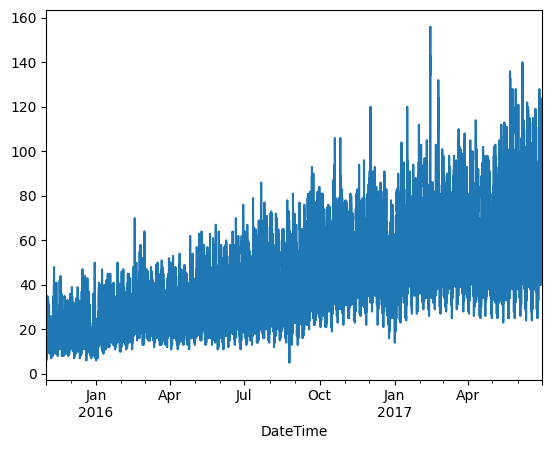

In [ ]:
junc1['Vehicles'].plot()

In [ ]:
# resample the data as daily average
daily_junc1 = junc1.Vehicles.resample('D').mean()
daily_junc1

DateTime
2015-11-01    13.625000
2015-11-02    22.750000
2015-11-03    22.666667
2015-11-04    20.750000
2015-11-05    19.333333
                ...    
2017-06-26    73.916667
2017-06-27    91.125000
2017-06-28    86.666667
2017-06-29    86.916667
2017-06-30    78.458333
Freq: D, Name: Vehicles, Length: 608, dtype: float64

In [ ]:
daily_junc1.shape

(608,)

<Axes: xlabel='DateTime'>

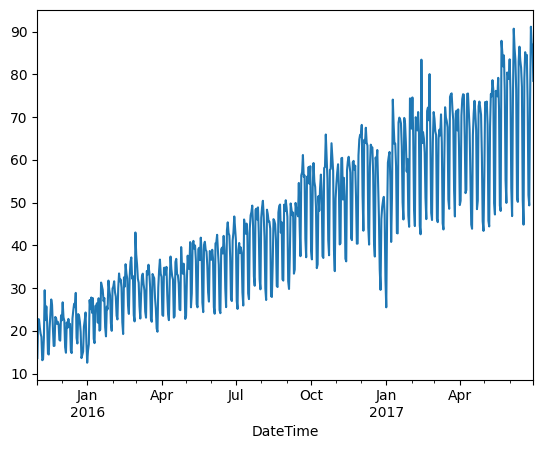

In [ ]:
daily_junc1.plot()

<Axes: >

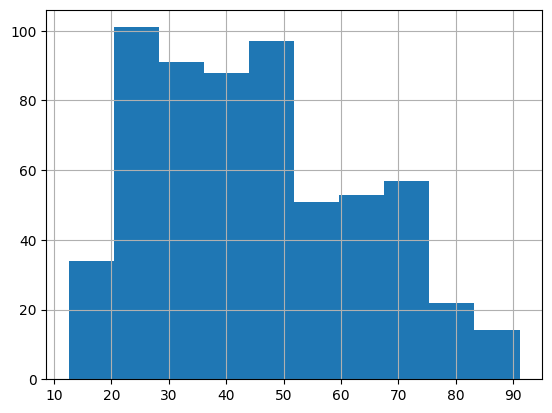

In [ ]:
# check the data distribution
daily_junc1.hist()

In [ ]:
# Defining a function that creates sequences and targets
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [ ]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [ ]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [ ]:
len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

601

In [ ]:
class SequenceDataset():
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [ ]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [ ]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [ ]:
len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

601

In [ ]:
dataset = SequenceDataset(sequences)

In [ ]:
split = 0.67 # Train/Test Split ratio

In [ ]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]

In [ ]:
lens

[402, 199]

In [ ]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

In [ ]:
# sequential split of dataset into train and test set
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

In [ ]:
BATCH_SIZE = 8 # Training batch size

In [ ]:
# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
# setting initial values and some bounds for them
ps = range(1, 3)
d=1
qs = range(1, 3)
Ps = range(1, 3)
D=1
Qs = range(1, 3)
s = 7 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

CPU times: user 1min 23s, sys: 1min 1s, total: 2min 25s
Wall time: 1min 51s


In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                          Vehicles   No. Observations:                  608
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -1580.540
Date:                           Wed, 05 Jun 2024   AIC                           3175.079
Time:                                   18:41:53   BIC                           3205.858
Sample:                               11-01-2015   HQIC                          3187.061
                                    - 06-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8313      0.035     23.969      0.000       0.763       0.899
ma.L1         -1.3776      0.036    -38.418

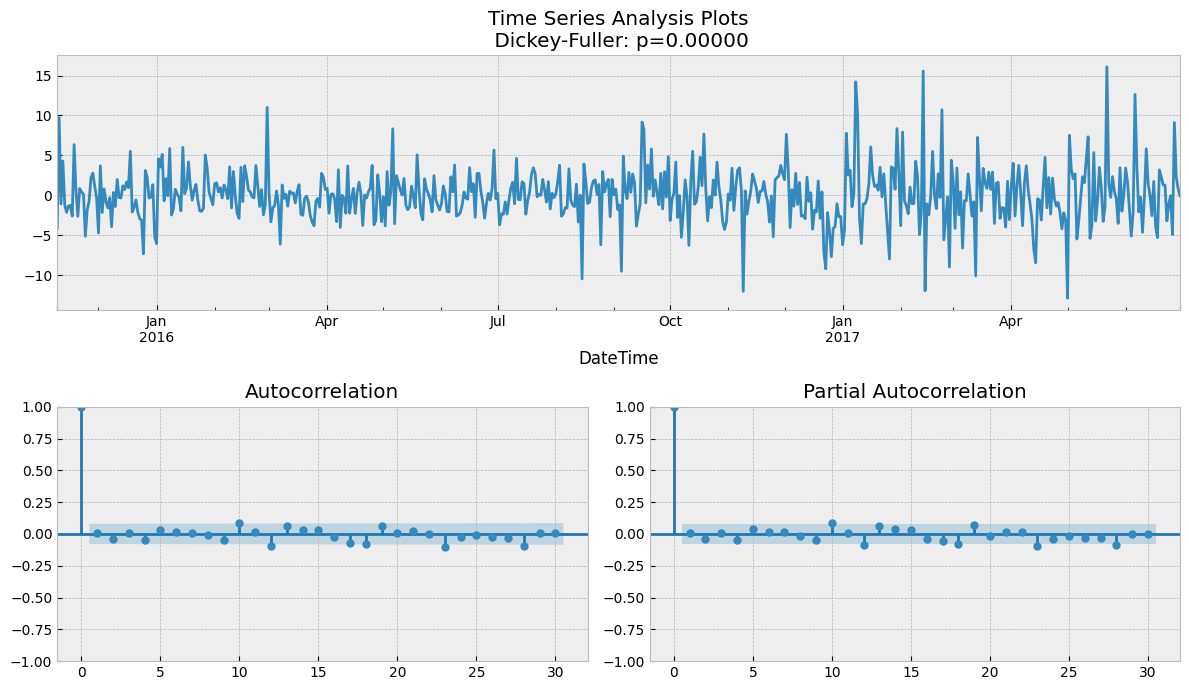

In [ ]:
tsplot(best_model.resid[7+1:], lags=30)

In [ ]:
from sklearn.metrics import mean_squared_error
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    #data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    # concatenate data.sarima_model and forecast
    forecast = pd.concat([data.sarima_model, forecast])
    # calculate error, again having shifted on s+d steps from the beginning
    #error = mean_absolute_percentage_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)
    error = mean_squared_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)

    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-2], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(daily_junc1, label="actual")
    plt.legend()
    plt.grid(True);

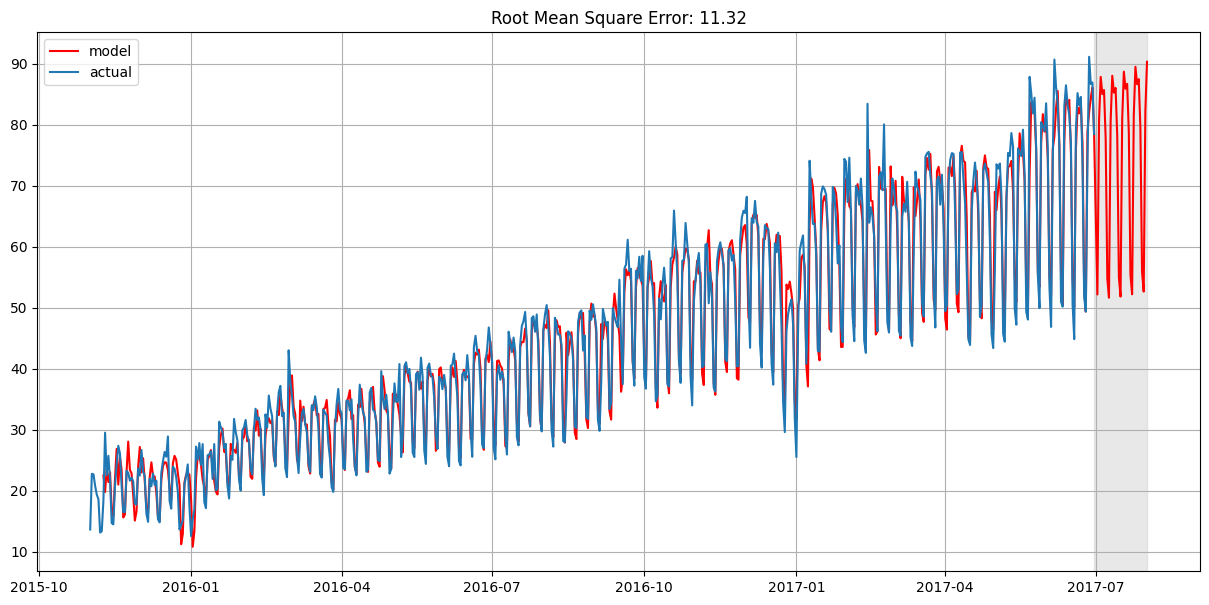

In [ ]:
plotSARIMA(daily_junc1, best_model, 30)

In [ ]:
sarima_forecast = best_model.predict(start = daily_junc1.shape[0], end = daily_junc1.shape[0]+30)
sarima_forecast

2017-07-01    55.463226
2017-07-02    52.151639
2017-07-03    80.667716
2017-07-04    87.824470
2017-07-05    84.994671
2017-07-06    85.680241
2017-07-07    77.798363
2017-07-08    54.782700
2017-07-09    51.620578
2017-07-10    80.511638
2017-07-11    88.013470
2017-07-12    85.233730
2017-07-13    86.022957
2017-07-14    78.137508
2017-07-15    54.957859
2017-07-16    51.803373
2017-07-17    80.942693
2017-07-18    88.683089
2017-07-19    85.873201
2017-07-20    86.697227
2017-07-21    78.754128
2017-07-22    55.371207
2017-07-23    52.186632
2017-07-24    81.534337
2017-07-25    89.479018
2017-07-26    86.618529
2017-07-27    87.458245
2017-07-28    79.444657
2017-07-29    55.853262
2017-07-30    52.629384
2017-07-31    82.169601
Freq: D, Name: predicted_mean, dtype: float64

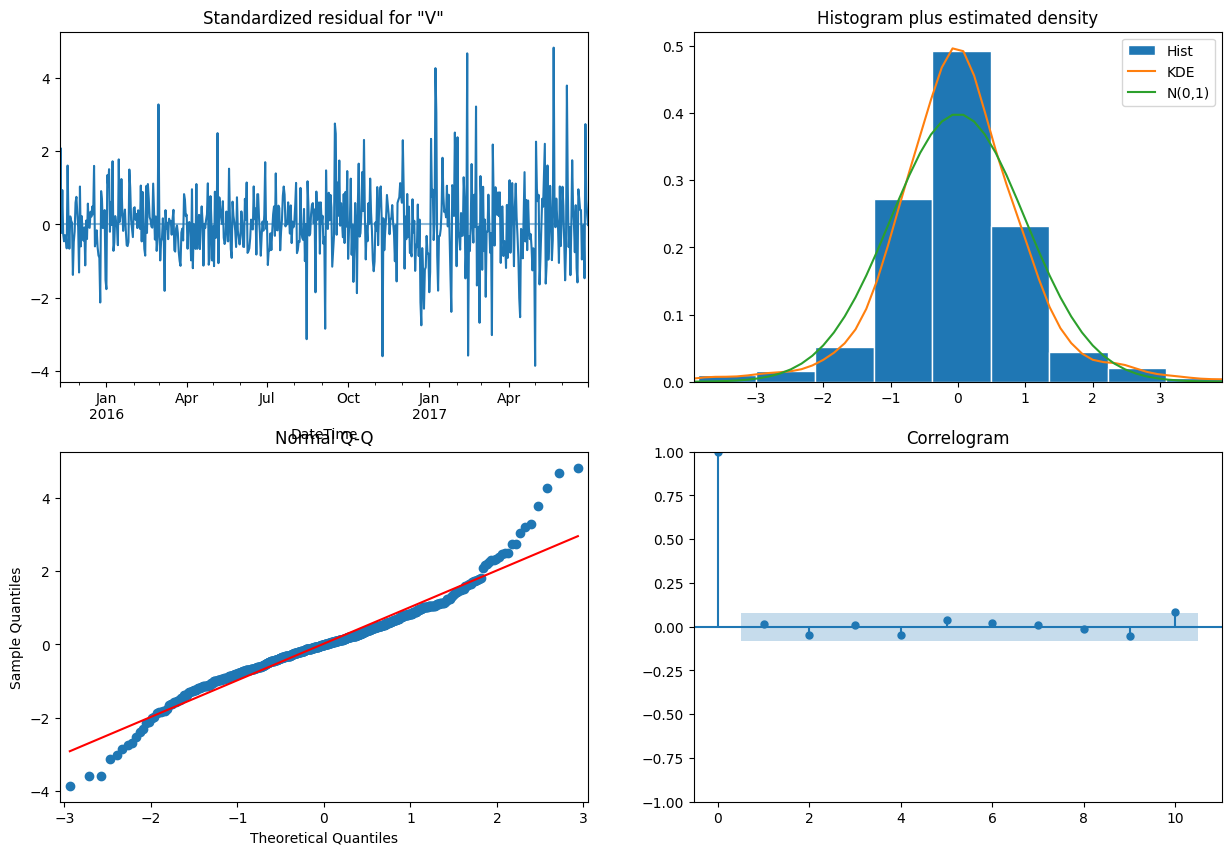

In [ ]:
best_model.plot_diagnostics(figsize=(15, 10))
plt.show()